# Sequence-to-Sequence Character Prediction: Comparing RNN, LSTM, and GRU Architectures

## Task to perform

Given an input sequence of lowercase English letters, the model should predict the same sequence with each character shifted forward by 1 in the alphabet.

Example:
Input: "abcxyz" → Target: "bcdyza"

In [16]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense
import matplotlib.pyplot as plt
import random
import string
from keras.src.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import numpy as np

# Synthesizing data

In [2]:
vocab = ["<pad>"] + list(string.ascii_lowercase)
vocab_size = len(vocab)
char_to_idx = {c: i for i, c in enumerate(vocab)}
idx_to_char = {i: c for c, i in char_to_idx.items()}

print(idx_to_char)

{0: '<pad>', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [3]:
def shift_letter(char):
    return chr((ord(char) - ord("a") + 1) % 26 + ord("a"))


def generate_sample(n=5000):
    x_data, y_data = [], []
    for _ in range(n):
        word = "".join(random.choices(string.ascii_lowercase, k=26))

        shifted = "".join(shift_letter(c) for c in word)
        x_data.append([char_to_idx[c] for c in word])
        y_data.append([char_to_idx[c] for c in shifted])
    return x_data, y_data


def text_to_indices(text, char_to_index):
    return [char_to_index[c] for c in text]


# Plot function

In [4]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.legend()

    plt.show()

# Training setup

In [5]:
x_train, y_train = generate_sample()
x_train = pad_sequences(x_train, maxlen=26, padding="post")
y_train = pad_sequences(y_train, maxlen=26, padding="post")

x_train, x_test, y_train, y_test =  train_test_split(x_train, y_train, test_size=0.2)

early_stop = EarlyStopping(monitor="accuracy", patience=3, restore_best_weights=True)

lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',    
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Training RNN

In [6]:
rnn_model = Sequential(
    [
        Embedding(input_dim=vocab_size, output_dim=32),
        SimpleRNN(64, return_sequences=True),
        Dense(vocab_size, activation="softmax"),
    ]
)

rnn_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

I0000 00:00:1749668449.617464    2214 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [7]:
rnn_history = rnn_model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[early_stop, lr_schedule])

Epoch 1/20


I0000 00:00:1749668451.338001    2345 service.cc:152] XLA service 0x7fec68009f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749668451.338059    2345 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-06-11 19:00:51.418223: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749668451.652840    2345 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-11 19:00:53.323756: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 40 bytes spill stores, 40 bytes spill loads



21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2034 - loss: 3.2076

I0000 00:00:1749668454.851960    2345 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-06-11 19:00:55.426795: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-06-11 19:00:56.243890: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.2413 - loss: 3.1803 - val_accuracy: 0.7347 - val_loss: 2.7045 - learning_rate: 0.0010
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8364 - loss: 2.4484 - val_accuracy: 0.9910 - val_loss: 1.5135 - learning_rate: 0.0010
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9963 - loss: 1.1823 - val_accuracy: 1.0000 - val_loss: 0.4082 - learning_rate: 0.0010
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.2966 - val_accuracy: 1.0000 - val_loss: 0.1097 - learning_rate: 0.0010
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0898 - val_accuracy: 1.0000 - val_loss: 0.0520 - learning_rate: 0.0010
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0461 - val_accuracy: 1.0000 - val_loss: 0.0328 - learning_rate: 0.0010
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0301 - val_accuracy: 1.00

# Training LSTM

In [8]:
lstm_model = Sequential(
    [
        Embedding(input_dim=vocab_size, output_dim=32),
        LSTM(64, return_sequences=True),
        Dense(vocab_size, activation="softmax"),
    ]
)

lstm_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [9]:
lstm_history = lstm_model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[early_stop, lr_schedule])

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.3388 - loss: 3.2528 - val_accuracy: 0.4302 - val_loss: 3.0527 - learning_rate: 0.0010
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5690 - loss: 2.8931 - val_accuracy: 0.9167 - val_loss: 2.1252 - learning_rate: 0.0010
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9637 - loss: 1.7293 - val_accuracy: 1.0000 - val_loss: 0.6969 - learning_rate: 0.0010
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.5221 - val_accuracy: 1.0000 - val_loss: 0.2058 - learning_rate: 0.0010
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.1691 - val_accuracy: 1.0000 - val_loss: 0.0970 - learning_rate: 0.0010
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0859 - val_accuracy: 1.0000 - val_loss: 0.0597 - learning_rate: 0.0010
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0547 - val_acc

# Training GRU

In [10]:
gru_model = Sequential(
    [
        Embedding(input_dim=vocab_size, output_dim=32),
        GRU(64, return_sequences=True), 
        Dense(vocab_size, activation="softmax"),
    ]
)

gru_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [11]:
gru_history = gru_model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[early_stop, lr_schedule])

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6348 - loss: 3.1809 - val_accuracy: 0.9131 - val_loss: 2.6747 - learning_rate: 0.0010
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9084 - loss: 2.3432 - val_accuracy: 0.9994 - val_loss: 1.1273 - learning_rate: 0.0010
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9999 - loss: 0.8037 - val_accuracy: 1.0000 - val_loss: 0.2102 - learning_rate: 0.0010
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.1572 - val_accuracy: 1.0000 - val_loss: 0.0686 - learning_rate: 0.0010
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0586 - val_accuracy: 1.0000 - val_loss: 0.0383 - learning_rate: 0.0010
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0347 - val_accuracy: 1.0000 - val_loss: 0.0261 - learning_rate: 0.0010
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0242 - val_acc

# Plotting Graphs & Accuracy

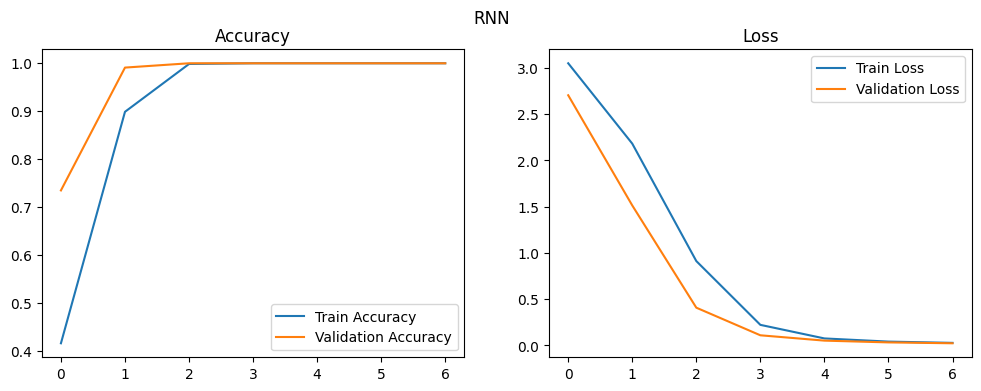

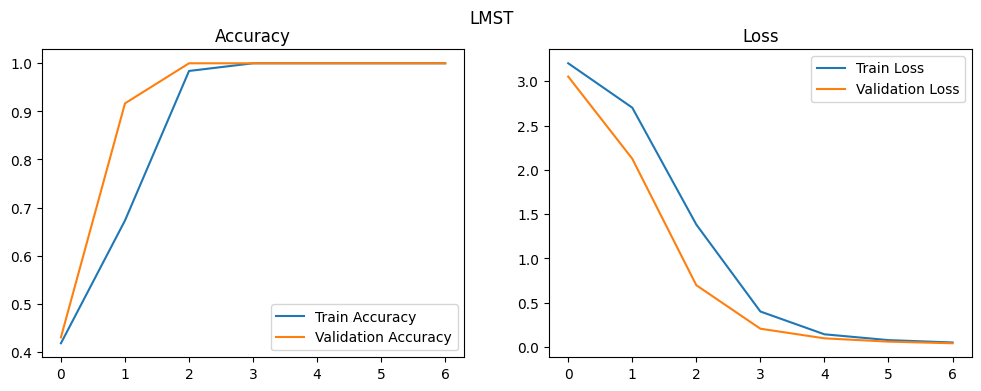

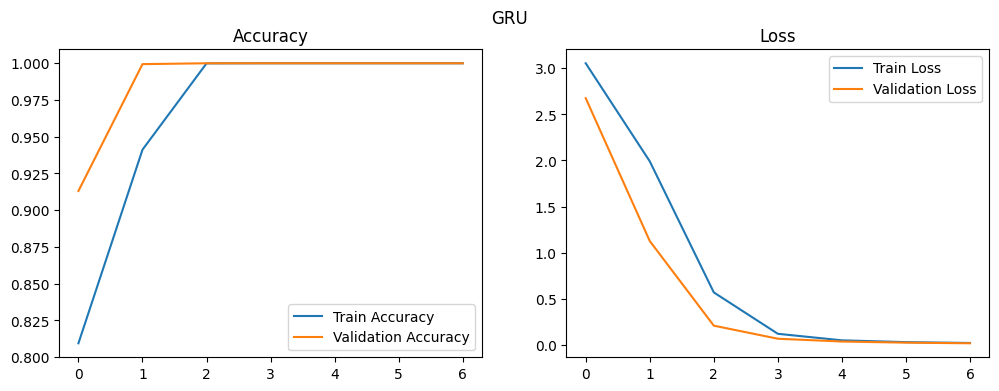

In [12]:
plot_history(rnn_history, "RNN")
plot_history(lstm_history, "LMST")
plot_history(gru_history, "GRU")

In [13]:
test_loss, test_acc = rnn_model.evaluate(x_test, y_test)
print(f"RNN Accuracy: {test_acc}")
test_loss, test_acc = lstm_model.evaluate(x_test, y_test)
print(f"LMST Accuracy: {test_acc}")
test_loss, test_acc = gru_model.evaluate(x_test, y_test)
print(f"GRU Accuracy: {test_acc}")

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.1097

2025-06-11 19:01:12.146607: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - loss: 0.1097
RNN Accuracy: 1.0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.2064
LMST Accuracy: 1.0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0689
GRU Accuracy: 1.0


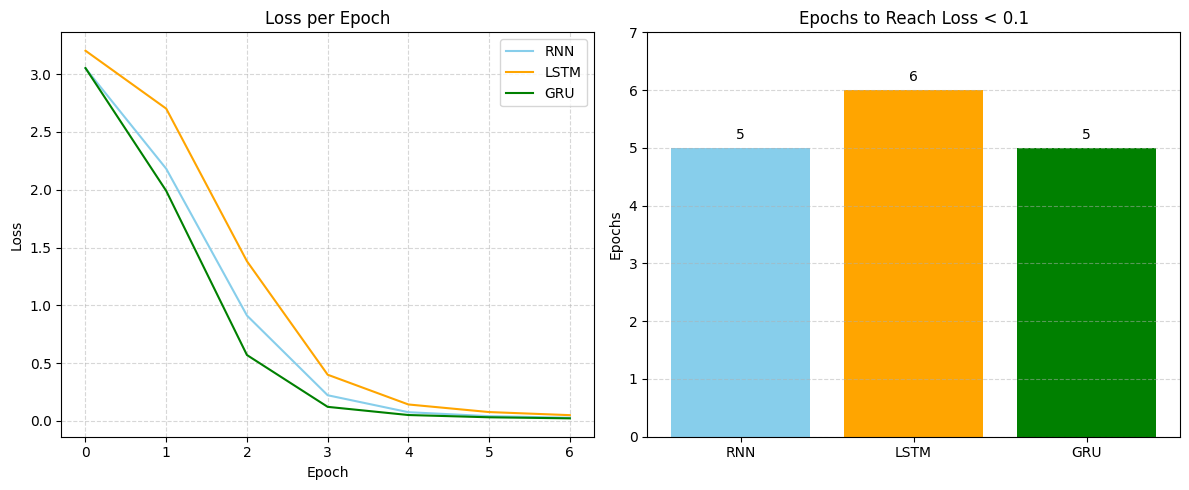

In [14]:
rnn_loss = rnn_history.history['loss']
lstm_loss = lstm_history.history['loss']
gru_loss = gru_history.history['loss']

def get_convergence_epoch(losses, threshold=0.1):
    for i, loss in enumerate(losses):
        if loss < threshold:
            return i + 1
    return len(losses)

rnn_epoch = get_convergence_epoch(rnn_loss)
lstm_epoch = get_convergence_epoch(lstm_loss)
gru_epoch = get_convergence_epoch(gru_loss)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(rnn_loss, label='RNN', color='skyblue')
axes[0].plot(lstm_loss, label='LSTM', color='orange')
axes[0].plot(gru_loss, label='GRU', color='green')
axes[0].set_title("Loss per Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

models = ["RNN", "LSTM", "GRU"]
epochs = [rnn_epoch, lstm_epoch, gru_epoch]
colors = ["skyblue", "orange", "green"]

axes[1].bar(models, epochs, color=colors)
axes[1].set_title("Epochs to Reach Loss < 0.1")
axes[1].set_ylabel("Epochs")
axes[1].set_ylim(0, max(epochs) + 1)
axes[1].grid(axis="y", linestyle="--", alpha=0.5)

for i, epoch in enumerate(epochs):
    axes[1].text(i, epoch + 0.1, str(epoch), ha='center', va='bottom')

plt.tight_layout()
plt.show()


# Testing

In [27]:

def test_word(model, word, maxlen=26):
    # Convert to indices
    input_seq = [[char_to_idx[c] for c in word]]
    input_seq = pad_sequences(input_seq, maxlen=26, padding="post")

    preds = model.predict(input_seq)
    pred_indices = np.argmax(preds, axis=-1)[0]  # shape: (seq_len,)
    return "".join([idx_to_char[i] for i in pred_indices])


test_input = "abcdefghijklmnopqrstuvwxyz"

rnn_out = test_word(rnn_model, test_input)
lstm_out = test_word(lstm_model, test_input)
gru_out = test_word(gru_model, test_input)

print(f"\nInput:     {test_input}\n")
print(f"RNN Out:   {rnn_out}")
print(f"LSTM Out:  {lstm_out}")
print(f"GRU Out:   {gru_out}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Input:     abcdefghijklmnopqrstuvwxyz

RNN Out:   bcdefghijklmnopqrstuvwxyza
LSTM Out:  bcdefghijklmnopqrstuvwxyza
GRU Out:   bcdefghijklmnopqrstuvwxyza


# Summary

### Task to perform

Given an input sequence of lowercase English letters, the model should predict the same sequence with each character shifted forward by 1 in the alphabet.

Example:
Input: "abcxyz" → Target: "bcdyza"

### Dataset Configuration

| Parameter          | Value                          |
|--------------------|--------------------------------|
| Vocabulary         | a-z (26 lowercase letters)    |
| Sequence Length    | 26 characters                 |
| Number of Samples  | 5,000 sequences               |
| Character Encoding | a=1 to z=25, padding=0        |
| Target Format      | Sequence of class indices     |



### Model & Training Configuration

| Component               | Specification                          |
|-------------------------|----------------------------------------|
| Embedding Layer         | output_dim=32                         |
| Recurrent Layer Options | SimpleRNN/LSTM/GRU (64 units)         |
| Output Layer            | Dense(26, activation='softmax')       |
| Loss Function           | Sparse categorical crossentropy       |
| Optimizer               | Adam                                  |
| Metrics                 | Accuracy                              |
| Epochs                  | 20 (early stopping at 5-7 epochs)     |
| Batch Size              | 128                                   |
| Validation Split        | 20%                                   |

### Performance Analysis

The training loss vs epochs for all three models is shown in the figure. Key observations:

- GRU converges the fastest, achieving near-zero loss by epoch 4.

- RNN follows closely but is less stable in the initial epochs.

- LSTM starts with a higher loss and converges more gradually.

All models eventually reach 100% training accuracy, indicating that the task is linearly separable and sufficiently simple for all architectures to solve.

Input: abcdefghijklmnopqrstuvwxyz

Expected output: bcdefghijklmnopqrstuvwxyza

| **Model** | **Output**                 |
| --------- | -------------------------- |
| RNN       | bcdefghijklmnopqrstuvwxyza |
| LSTM      | bcdefghijklmnopqrstuvwxyza |
| GRU       | bcdefghijklmnopqrstuvwxyza |